<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/003_TensorFlow_Proj_Three_FFNN_PolynomialCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [3]:
# utils
import itertools
import glob, os, sys, shutil
import math
import numpy as np
import pandas as pd
from random import (randint, sample, choice)
# google
from google.colab import drive
# display
from IPython.display import Image
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, load_model)
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPool2D,
                                     AvgPool2D, Activation, Input,
                                     BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (CategoricalCrossentropy,
                                      SparseCategoricalCrossentropy,
                                      BinaryCrossentropy)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
# matplotlib
import matplotlib.pyplot as plt

In [4]:
# GPU
physical_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
print("No. GPUs available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)

No. GPUs available:  0


In [5]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# curr dir
os.getcwd()
# os.chdir("drive/MyDrive/") # change dir

'/content'

In [7]:
# create data set
def create_data(samples):
	points = []
	for i in range(samples):
		x = np.random.uniform(-5, 5)
		y = np.random.uniform(-5, 5)

		if -1 < x < 0:
			if y > math.sin(x) and y < x**2*math.sin(x):
				label = 0
			elif y < math.tan(x):
				label = 0
			elif y > math.log(x+7):
				label = 0
			else:
				label = 1

		if 0 < x < 1:
			if y < math.sin(x) and y > x**2*math.sin(x):
				label = 0
			elif y > math.tan(x) and y < math.log(x+7):
				label = 0
			else:
				label = 1

		if 1 < x < 2.858:
			if y > math.sin(x) and y < math.log(x+7):
				label = 0
			elif y > math.sin(x) and y > x**2*math.sin(x):
				label = 0
			elif y < math.tan(x):
				label = 0
			else:
				label = 1

		if -1 > x > -math.pi:
			if y < math.sin(x) and y > math.sin(x)*x**2:
				label=0
			elif y > math.tan(x) and y < math.log(x+7):
				label = 0
			else:
				label = 1

		if x > 2.858:
			if y > math.sin(x)*x**2 and y > math.tan(x) and y < math.log(x+7):
				label = 1
			else:
				label = 0

		if x < -math.pi:
			if y > math.sin(x) and y < math.log(x+7) and y < math.sin(x)*x**2:
				label = 1
			elif y < math.tan(x):
				label = 1
			elif y > math.log(x+7) and y < math.sin(x):
				label = 1
			else:
				label = 0

		points.append([x,y,label])

	df = pd.DataFrame(np.array(points), columns=['x','y','color'])

	return df

## BiLinear Model

In [8]:
# gen sample
def bi_linear(samples):
  # red points
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue points
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # stack and return df
  final= np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])

# define colors
color_dict = {0: 'red', 1: 'blue'}
# train df
n_train =1000
train_df = bi_linear(n_train)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
n_test = 200
test_df = bi_linear(n_test)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save data frames
graph = 'linear'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

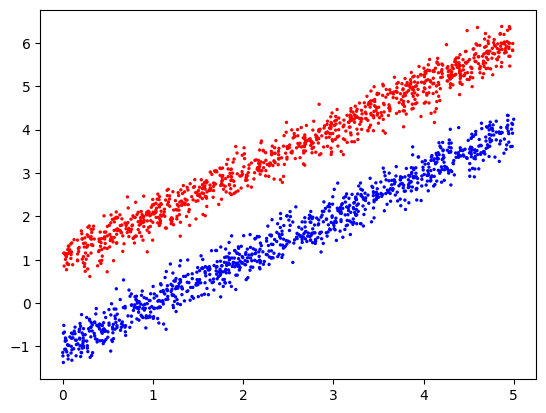

In [9]:
# plot
plt.figure()
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
plt.show()

In [10]:
# shuffle
np.random.shuffle(train_df.values)

In [11]:
print(train_df.head())

          x         y color
0  4.986947  5.835739   red
1  2.091460  2.674667   red
2  4.719927  5.751106   red
3  0.337248  1.705835   red
4  4.015927  5.336104   red


In [12]:
# shallow N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values
test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=40)
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4878 - loss: 1.3158
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4924 - loss: 1.0218
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5675 - loss: 0.7405
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8413 - loss: 0.5399
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9960 - loss: 0.4403
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 0.3796
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 0.3322
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.2907
Epoch 9/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.2568
Epoch 10/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.2268
Epoch 11/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.2005
Epoch 12/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

[0.012931379489600658, 1.0]

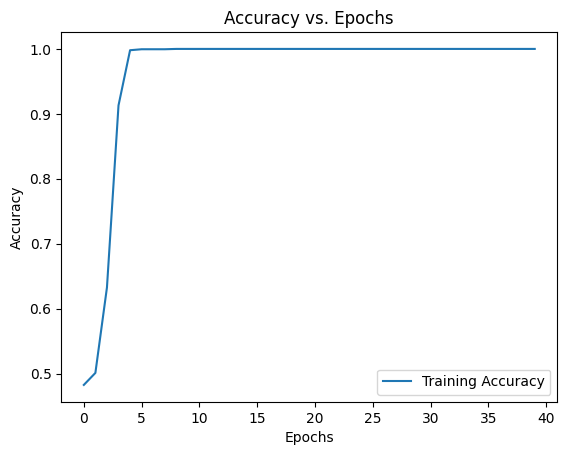

In [13]:
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## TriLines Model

In [45]:
def three_lines(samples):
  # red
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # green
  x3 = np.random.uniform(0,5,samples)
  y3 = x3 - np.random.normal(5,0.25, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # stack and return
  final= np.row_stack((red,blue,green))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
# train df
train_df = three_lines(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
test_df = three_lines(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save data frames
graph = 'linear_multigroup'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

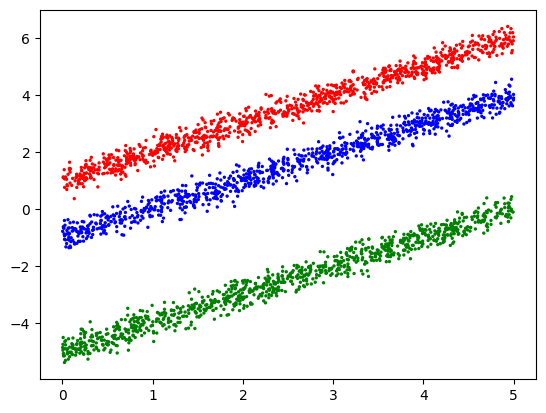

In [46]:
# plot
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [47]:
# shuffle
np.random.shuffle(train_df.values)

In [48]:
print(train_df.head())

          x         y color
0  4.639257  5.559859   red
1  2.792252  3.674093   red
2  0.330865  1.572138   red
3  4.276041  5.161510   red
4  1.118916  2.174872   red


In [49]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(3, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="categorical_crossentropy",
	          metrics=['accuracy'])
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=False).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=False).values
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=40)
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1111 - loss: 1.4962
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6338 - loss: 0.9055
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7403 - loss: 0.6187
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8172 - loss: 0.4905
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8824 - loss: 0.3852
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9284 - loss: 0.3254
Epoch 7/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9460 - loss: 0.2521
Epoch 8/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9650 - loss: 0.1922
Epoch 9/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9731 - loss: 0.1579
Epoch 10/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9904 - loss: 0.1173
Epoch 11/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9949 - loss: 0.0999
Epoch 12/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

[0.00044871249701827765, 1.0]

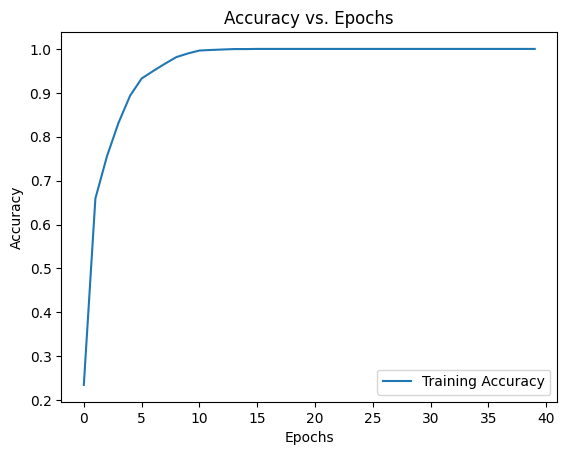

In [50]:
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Quadratic Model

In [20]:
def quadratic(samples):
  # Red
  x1 = np.random.uniform(-5,5, samples)
  y1 = x1**2 + np.random.uniform(1,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue
  x2 = np.random.uniform(-5,5,samples)
  y2 = x2**2 - np.random.uniform(1,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Stack and return
  final = np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue'}
# Train df
train_df = quadratic(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
test_df = quadratic(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save data frames
graph = 'quadratic'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

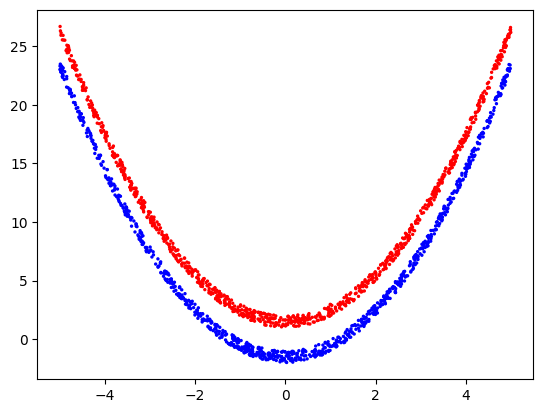

In [21]:
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [22]:
# shuffle
np.random.shuffle(train_df.values)

In [23]:
print(train_df.head())

          x          y color
0 -2.297014   6.407352   red
1  1.383682   3.162291   red
2  4.145694  18.932320   red
3 -0.254924   1.756056   red
4 -3.824891  15.987277   red


In [24]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=40               )
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7228 - loss: 0.6797
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7387 - loss: 0.6099
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7080 - loss: 0.5591
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7260 - loss: 0.5315
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7598 - loss: 0.4930
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7622 - loss: 0.4781
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7759 - loss: 0.4670
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7996 - loss: 0.4505
Epoch 9/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8105 - loss: 0.4354
Epoch 10/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8407 - loss: 0.4112
Epoch 11/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8425 - loss: 0.3962
Epoch 12/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

[0.055747803300619125, 1.0]

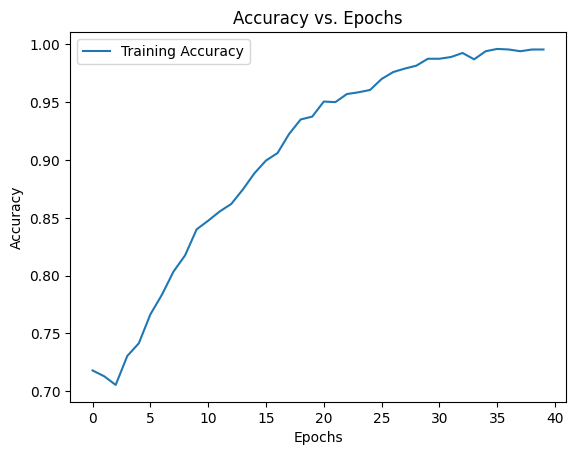

In [25]:
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Cluster  Model

In [26]:
def clusters(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  teal = np.column_stack((x4,y4,z4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  orange = np.column_stack((x5,y5,z5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  purple = np.column_stack((x6,y6,z6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
# train df
train_df = clusters(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
test_df = clusters(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save frames
graph = 'clusters_multi_categories'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

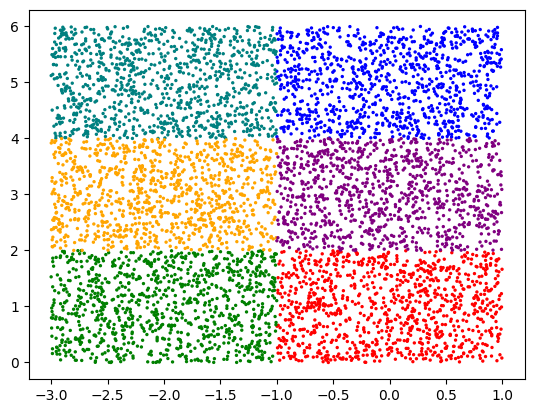

In [27]:
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [28]:
# enumerate colors
color_dict = {'red': 0, 'blue': 1, 'green': 2, 'teal': 3, 'orange': 4, 'purple': 5}
train_df['color'] = train_df.color.apply(lambda x: color_dict[x])

In [29]:
# shuffle
np.random.shuffle(train_df.values)
print(train_df.head())
print(train_df.color.unique())

          x         y  color
0 -0.044415  0.866862      0
1 -0.680466  1.414441      0
2 -0.811450  1.519176      0
3  0.863588  1.131627      0
4  0.698062  1.484492      0
[0 1 2 3 4 5]


In [30]:
# stack features
train_x = np.column_stack((train_df.x.values, train_df.y.values))
test_x = np.column_stack((test_df.x.values, test_df.y.values))

In [31]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(6, activation='softmax')])
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(train_x, train_df.color.values, batch_size=5, epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6094 - loss: 1.0536
Epoch 2/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9303 - loss: 0.2390
Epoch 3/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9621 - loss: 0.1467
Epoch 4/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9652 - loss: 0.1134
Epoch 5/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9699 - loss: 0.0972
Epoch 6/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9682 - loss: 0.0933
Epoch 7/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9723 - loss: 0.0806
Epoch 8/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9699 - loss: 0.0859
Epoch 9/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9748 - loss: 0.0740
Epoch 10/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9735 - loss: 0.0659
Epoch 11/30
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9775 - loss: 0.0630
Epoch 12/30
1200/1200 ━━━━━━━━━━━━━━━━━━━

In [32]:
# evaluate
print("EVALUATION")
test_df['color'] = test_df.color.apply(lambda x: color_dict[x])
model.evaluate(test_x, test_df.color.values)
print("Prediction", np.round(model.predict(np.array([[0,3]]))))

EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9824 - loss: 0.0399  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction [[0. 0. 0. 0. 0. 1.]]


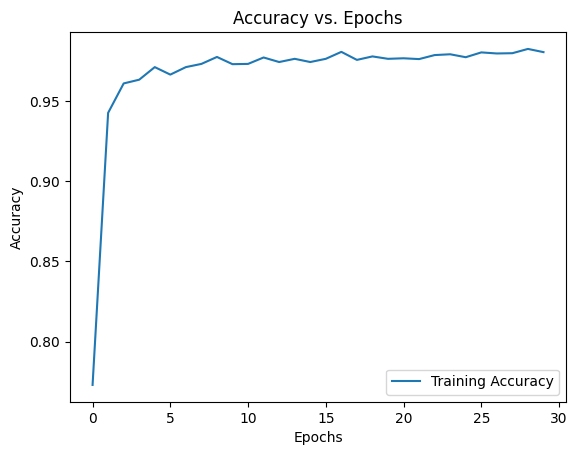

In [33]:
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Cluster Model - OneHot Encoder

In [34]:
def clusters_advanced(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])

# color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}

# train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

In [35]:
# one-hot encoders
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))

In [36]:
# shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)

In [37]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(64, activation='relu'),
  keras.layers.Dropout(0.4),
 	keras.layers.Dense(32, activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(16, activation='relu'),
  keras.layers.Dropout(0.4),
	keras.layers.Dense(9, activation='sigmoid')])
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(x, train_labels, batch_size=10, epochs=40)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0630 - loss: 0.5640
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0708 - loss: 0.3356
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1359 - loss: 0.2574
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1545 - loss: 0.2217
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2164 - loss: 0.1882
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2263 - loss: 0.1740
Epoch 7/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2343 - loss: 0.1608
Epoch 8/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2271 - loss: 0.1553
Epoch 9/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2365 - loss: 0.1538
Epoch 10/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2862 - loss: 0.1344
Epoch 11/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2691 - loss: 0.1408
Epoch 12/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy

In [38]:
# evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))

EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0250 - loss: 0.0461      
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction [[0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]]


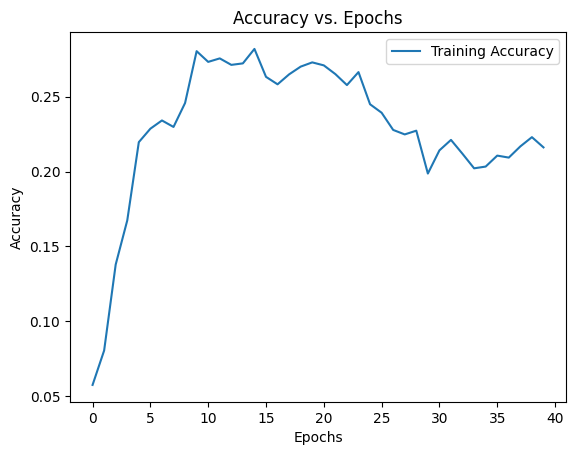

In [39]:
# plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

# Cluster Model - Advanced

In [40]:
def clusters_advanced(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])
# color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}
# train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

In [41]:
# one-hot encoders
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))
# shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)

In [42]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(9, activation='softmax')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(x, train_labels, batch_size=20, epochs=10)
# evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0715 - loss: 0.4949
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2360 - loss: 0.1834
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3666 - loss: 0.1147
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3846 - loss: 0.0662
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3453 - loss: 0.0534
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3422 - loss: 0.0411
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3188 - loss: 0.0374
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3172 - loss: 0.0351
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3412 - loss: 0.0323
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3259 - loss: 0.0292
EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2815 - loss: 0.0168  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction [[0.

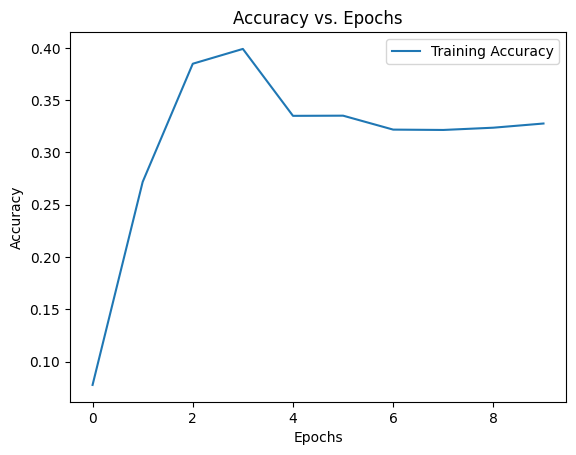

In [44]:
# plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()